In [17]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from konlpy.tag import Mecab
from collections import Counter

In [37]:
# 데이터를 읽어봅시다. 
train_data = pd.read_csv('~/aiffel/sentiment_classification/data/ratings_train.txt', delimiter='\t')
test_data = pd.read_csv('~/aiffel/sentiment_classification/data/ratings_test.txt', delimiter='\t')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


* 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 
* 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 
* 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. 
* data_loader 안에서는 다음을 수행해야 합니다.
    * 데이터의 중복 제거
    * NaN 결측치 제거
    * 한국어 토크나이저로 토큰화
    * 불용어(Stopwords) 제거
    * 사전word_to_index 구성
    * 텍스트 스트링을 사전 인덱스 스트링으로 변환
    * X_train, y_train, X_test, y_test, word_to_index 리턴

## 전처리

In [20]:
train_data['document'].duplicated().value_counts()

False    146183
True       3817
Name: document, dtype: int64

In [21]:
train_data['document'].isnull().value_counts()

False    149995
True          5
Name: document, dtype: int64

In [22]:
train_data[train_data['document'].str.contains('O', na=False)]

,id,document,label
53,7865630,"난또 저 꼬마애가 무슨 원한이 깊길래.,. 했더니 OO 그냥 혼자 나대다 OO걸 어...",0
262,5124760,아 OOO기.. 이걸 본 내눈이 아깝다 ㅡㅡ 진짜 아놔 진짜 OOO기명작이네요,0
263,6931068,필름값이 아깝다..재미 더럽게없다..2점부터 점수준것들 매미 OO,0
269,10274403,OOO영화 뭘전달하려는지모르겠네 오글거리고,0
387,10232830,림프비즈킷의 OST만 10점. 개봉 당시 극장에서 봤는데 영화내내 오우삼 쥑이고 싶...,0
...,...,...,...
149625,8882106,평점 주기도 아깝다 고은정 OOO 깉은 거시기도 그렇고 역기들 더럽게 못한다 허비한...,0
149690,9939429,좋은 영화는 OOO CG도배가 아니라 이런 탄탄한 스토리와 뭔가 묵직한 것을 가슴에...,1
149706,9427140,OOO~ 시간 버리지마삼~,0
149949,3924716,OO 영화,0


### formal 하지 않은 웹 상에서 감정 분석을 진행하면, 욕설은 굉장히 중요한 요소일 것

In [23]:
train_data[train_data['document'].str.contains('쓰레기', na=False)]

,id,document,label
31,9005897,졸쓰레기 진부하고말도안됌ㅋㅋ 아..시간아까워,0
84,9875922,정말쓰레기영화입니다,0
119,9753792,절대 보지마라 쓰레기 영화,0
232,8309459,하..진짜 댓글보고 한번쯤볼만한 영화인거같아서봤지만 기가찬다..이게무슨버킷리스트인가...,0
307,7713083,쓰레기 연예인 재기의 장~~그러나...,0
...,...,...,...
149734,5530071,그럴 듯 하게 포장했지만.. 쓰레기통..,0
149738,7340570,안봐도 걍 개ㅈ쓰레기 보슬영화네ㅉㅉ 아참 영화도 아니지이건,0
149745,5383356,피터잭슨도 이런 쓰레기 영화에서 출발했었구나 역시 저자본 영화는 연출이 병맛,0
149771,2325900,정말 쓰레기다. 감독도 다음작품 내지도 못했음 ㅉㅉ 여자배우 몸이라도 이뻤으면,0


In [24]:
train_data[train_data['document'].str.contains('ㅈ', na=False)]

,id,document,label
67,7956793,김남길의 백점짜리 연기력과 초반 몰입도에도 불구하고 지루하고 손예진 ㅈㅈ,0
165,10122280,"""영화 끝나갈때쯤에 멍하다가 다보고나면 한마디 나올거임 """"ㅈ같다.""""""",1
1091,9431078,훈훈한만남. . .가슴따듯ㅈ해짐,1
1727,5213934,이거평점이해가안가 ㅈㄴ재미없엇는대,0
2135,7974428,아니 왜왜왜 증거도 있는데 미궁사건이여 참 이해 못하겄내 ㅅㅂ 이러면 안되는데 사고...,1
...,...,...,...
148444,10264971,개ㅈ노잼 이딴걸 미쳤다고 돈주고 보냐,0
148673,880472,ㅈㅐ밌어요 ㅋㅋ,1
149010,7920696,ㅈㄴ 김,0
149738,7340570,안봐도 걍 개ㅈ쓰레기 보슬영화네ㅉㅉ 아참 영화도 아니지이건,0


#### 반어법은? 

In [25]:
mecab = Mecab()
sentence = train_data['document'][0]
morphs = mecab.morphs(sentence)
print(morphs)
pos = mecab.pos(sentence)
print(pos)
nouns = mecab.nouns(sentence)
print(nouns)  # ['나', '밥']

['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']
[('아', 'IC'), ('더', 'MAG'), ('빙', 'MAG'), ('.', 'SF'), ('.', 'SY'), ('진짜', 'MAG'), ('짜증', 'NNG'), ('나', 'NP'), ('네요', 'VCP+EC'), ('목소리', 'NNG')]
['짜증', '나', '목소리']


In [34]:
import re

def remove_punctuation(text):
    # 정규표현식으로 한글, 공백 빼고 전부 제거
    return re.sub(r'[^가-힣\s]', '', text)

In [40]:
tokenizer = Mecab()
# ? 불용어 이걸로 충분할까? 
stopwords = stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다',
    '그', '저', '것', '같다', '때문', '있다', '없다', '더', '하지만', '또한','그리고', '근데', '그래서', '즉', '뭐','이게','고','에서',
    '아서','인가','다','구나','네요','요']

def preprocess_data(data, text_column):
    # 중복 제거
    data = data.drop_duplicates(subset=[text_column])
    # 결측치 제거
    data = data.dropna(subset=[text_column])
    # 구두점 제거
    data[text_column] = data[text_column].apply(remove_punctuation)
    # 토큰화 및 불용어 제거
    data['tokenized'] = data[text_column].apply(
        lambda x: [word for word in tokenizer.morphs(x) if word not in stopwords]
    )
    return data

In [41]:
# 1차 전처리 결과 -> tokenized
train_data = preprocess_data(train_data, text_column='document')
test_data = preprocess_data(test_data, text_column='document')

In [42]:
train_data

,id,document,label,tokenized
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 빙, 진짜, 짜증, 나, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너무, 재, 밓었다그래서보는것을추천한다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 구먼, 솔직히, 재미, 없, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이몬페그, 익살, 스런, 연기, 돋보였, 던, 영화, 스파이더맨, 늙, 어, 보..."
...,...,...,...,...
149994,9458520,디케이드 다음에 더블 다음에 오즈인데 더블은 조금밖에 안나오네요,1,"[디, 케이드, 다음, 더블, 다음, 오즈, 인데, 더블, 조금, 밖에, 안, 나오]"
149995,6222902,인간이 문제지 소는 뭔죄인가,0,"[인간, 문제지, 소, 뭔, 죄]"
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0,"[한국인, 거들먹거리, 필리핀, 혼혈, 착하]"
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1,"[청춘, 영화, 최고봉, 방황, 우울, 했, 던, 날, 자화상]"


#### 명사 빈도 카운트 flatten 시켜서 전체 처리하면 약 27시간 소요

In [30]:
# from konlpy.tag import Hannanum
# from multiprocessing import Pool
# import pandas as pd
# from tqdm import tqdm

# # 병렬 처리
# def extract_nouns(row):
#     hannanum = Hannanum()  # 병렬 환경에서는 객체를 각 프로세스에서 초기화해야 함
#     sentence = ' '.join(row)  # 토큰 리스트를 문자열로 변환
#     return hannanum.nouns(sentence)  # 명사 추출

# # 2. 병렬 처리 실행
# with Pool(processes=4) as pool:  # 4개의 프로세스를 사용
#     # tqdm을 사용해 진행 상태 표시
#     result = list(tqdm(pool.imap(extract_nouns, train_data['tokenized'].tolist()), 
#                        desc="Processing rows", total=len(train_data)))

# # 3. 결과 병합
# nouns = [word for sublist in result for word in sublist]

# # 4. 명사를 데이터프레임으로 변환
# df_word = pd.DataFrame({"word": nouns})

# # 5. 글자 수 필터링
# df_word["count"] = df_word["word"].str.len()
# df_word = df_word.query("count >= 2")

# # 6. 단어별 빈도 계산
# df_word = df_word.groupby("word", as_index=False) \
#     .agg(n=("word", "size")) \
#     .sort_values("n", ascending=False)

# # 7. 상위 20개 단어 추출
# top20 = df_word.head(20)

# # 결과 확인
# print(top20)

In [43]:
def load_data(train_data, test_data, text_column, label_column, num_words=10000):
    """
    train_data, test_data : 1차 전처리된 데이터프레임
    text_column : 텍스트 열
    label_column : 라벨 열
    num_words: 어휘사전크기
    """

    # word_to_index
    words = [word for tokens in train_data['tokenized'] for word in tokens]
    word_freq = Counter(words)
    vocab = [word for word, freq in word_freq.most_common(num_words - 3)]  # PAD(0), BOS(1), UNK(2) 제외
    word_to_index = {word: idx + 3 for idx, word in enumerate(vocab)}  # 3부터 시작 
    word_to_index['<PAD>'] = 0
    word_to_index['<BOS>'] = 1
    word_to_index['<UNK>'] = 2

    def encode_sentence(tokens, word_to_index):
        # 시작 <BOS> 토큰 추가, 사전에 없는 단어는 <UNK>로 처리
        encoded = [word_to_index['<BOS>']]
        encoded.extend([word_to_index.get(word, 2) for word in tokens])  
        return encoded

    # 인덱싱
    X_train = train_data['tokenized'].apply(lambda x: encode_sentence(x, word_to_index)).tolist()
    y_train = train_data[label_column].values
    X_test = test_data['tokenized'].apply(lambda x: encode_sentence(x, word_to_index)).tolist()
    y_test = test_data[label_column].values

    return X_train, y_train, X_test, y_test, word_to_index

In [44]:
# 로드 
X_train, y_train, X_test, y_test, word_to_index = load_data(
    train_data=train_data,
    test_data=test_data,
    text_column='document',
    label_column='label'
)

In [45]:
X_train

[[1, 23, 853, 28, 192, 12, 665],
 [1, 958, 453, 461, 606, 3, 99, 1512, 40, 832, 910, 8, 32],
 [1, 16, 175, 2],
 [1, 7991, 129, 4002, 254, 75, 10, 44, 3285],
 [1,
  2,
  8451,
  1013,
  40,
  2653,
  47,
  3,
  2576,
  1076,
  24,
  299,
  30,
  14,
  29,
  47,
  2,
  2,
  366,
  2764,
  1629],
 [1, 595, 2, 2, 397, 156, 1421, 628, 1551, 639, 39, 2, 3, 211, 1318, 674],
 [1, 216, 324, 5, 326, 1873, 43, 8, 748],
 [1,
  211,
  1318,
  121,
  363,
  676,
  2,
  2,
  40,
  1390,
  244,
  81,
  212,
  20,
  839,
  21,
  297,
  578,
  471,
  447,
  517,
  3123,
  8452,
  14,
  1341,
  1341,
  58,
  259,
  10,
  40,
  84,
  4,
  59,
  14,
  2,
  31],
 [1, 105, 10, 15, 75, 9, 244, 18, 37, 3],
 [1,
  49,
  581,
  44,
  204,
  669,
  507,
  70,
  14,
  451,
  1359,
  566,
  658,
  64,
  14,
  16,
  2,
  9,
  12],
 [1, 2],
 [1,
  70,
  61,
  377,
  2275,
  87,
  180,
  51,
  81,
  159,
  2468,
  809,
  2,
  611,
  2577,
  2085,
  6359],
 [1, 240, 91, 2, 2, 7560, 2, 61, 2, 375, 3704, 40, 1218, 7, 164

In [46]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  13.677352112970384
문장길이 최대 :  78
문장길이 표준편차 :  10.507228284037351


In [50]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면? 정규화 이상치 제거에서국룰은 3시그마다. 약 99.7퍼 포함
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

pad_sequences maxlen :  45
전체 문장의 0.9726298631754374%가 maxlen 설정값 이내에 포함됩니다. 


In [52]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(143146, 45)


In [55]:
143146*0.3

42943.799999999996

In [56]:
# 7:3 train, val set 분리
x_val = X_train[:42944]   
y_val = y_train[:42944]

partial_x_train = X_train[42944:]  
partial_y_train = y_train[42944:]
print(type(partial_x_train))
print(partial_x_train.shape)
print(partial_y_train.shape)

partial_x_train = np.array(partial_x_train)
partial_y_train = np.array(partial_y_train)

print(type(partial_x_train))

<class 'numpy.ndarray'>
(100202, 45)
(100202,)
<class 'numpy.ndarray'>


### LSTM

In [67]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))   
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 328,993
Trainable params: 328,993
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 



history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
392/392 [==============================] - 4s 7ms/step - loss: 0.5229 - accuracy: 0.6976 - val_loss: 0.3784 - val_accuracy: 0.8327
Epoch 2/15
392/392 [==============================] - 2s 6ms/step - loss: 0.3513 - accuracy: 0.8470 - val_loss: 0.3667 - val_accuracy: 0.8379
Epoch 3/15
392/392 [==============================] - 2s 6ms/step - loss: 0.3250 - accuracy: 0.8594 - val_loss: 0.3747 - val_accuracy: 0.8381
Epoch 4/15
392/392 [==============================] - 2s 6ms/step - loss: 0.3033 - accuracy: 0.8682 - val_loss: 0.3819 - val_accuracy: 0.8405
Epoch 5/15
392/392 [==============================] - 2s 6ms/step - loss: 0.2825 - accuracy: 0.8751 - val_loss: 0.3728 - val_accuracy: 0.8390
Epoch 6/15
392/392 [==============================] - 2s 6ms/step - loss: 0.2615 - accuracy: 0.8833 - val_loss: 0.3886 - val_accuracy: 0.8361
Epoch 7/15
392/392 [==============================] - 2s 6ms/step - loss: 0.2435 - accuracy: 0.8919 - val_loss: 0.4176 - val_accuracy: 0.8388
Epoch 

In [69]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1509/1509 - 3s - loss: 0.5328 - accuracy: 0.8265
[0.5327699184417725, 0.8264653086662292]


In [70]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


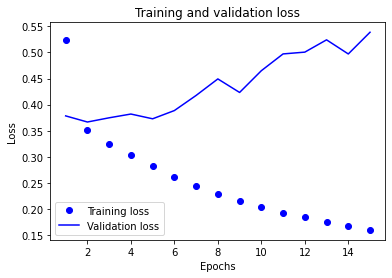

In [71]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

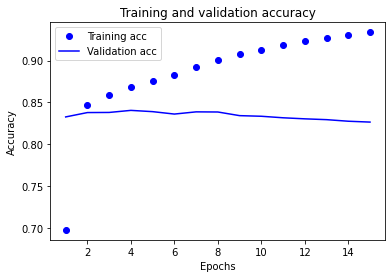

In [72]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* 갈 길이 멀다. 

### 양방향 LSTM

In [76]:
vocab_size = 10000 
word_vector_dim = 32 

# 모델 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

# 양방향 LSTM + Dropout + 배치 정규화
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())

# gpt가 양방향 LSTM층을 하나 더 넣으면 학습하는데 더 좋다고 한다.  한 번 넣어보자. 
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())

# Dense LAYER
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())

# 출력 시그모이드
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         49664     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 128)         512       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)              

In [77]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 콜백 
checkpoint_path = "best_model.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',  # val_accuracy 가 가장 높은거
                             save_best_only=True,
                             verbose=1)

In [78]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/15
392/392 [==============================] - 14s 21ms/step - loss: 0.6910 - accuracy: 0.6078 - val_loss: 0.5279 - val_accuracy: 0.7484

Epoch 00001: val_accuracy improved from -inf to 0.74842, saving model to best_model.h5
Epoch 2/15
392/392 [==============================] - 7s 18ms/step - loss: 0.4953 - accuracy: 0.7638 - val_loss: 0.4452 - val_accuracy: 0.7957

Epoch 00002: val_accuracy improved from 0.74842 to 0.79571, saving model to best_model.h5
Epoch 3/15
392/392 [==============================] - 7s 18ms/step - loss: 0.4348 - accuracy: 0.8095 - val_loss: 0.3753 - val_accuracy: 0.8360

Epoch 00003: val_accuracy improved from 0.79571 to 0.83604, saving model to best_model.h5
Epoch 4/15
392/392 [==============================] - 7s 18ms/step - loss: 0.4040 - accuracy: 0.8308 - val_loss: 0.3916 - val_accuracy: 0.8194

Epoch 00004: val_accuracy did not improve from 0.83604
Epoch 5/15
392/392 [==============================] - 7s 18ms/step - loss: 0.3801 - accuracy: 0.8442 

In [79]:
# 제일 좋은 가중치 로드
model.load_weights(checkpoint_path)

# 평가
results = model.evaluate(X_test, y_test, verbose=2)
print("Test Loss, Test Accuracy:", results)

1509/1509 - 7s - loss: 0.4708 - accuracy: 0.8374
Test Loss, Test Accuracy: [0.4708107113838196, 0.837425172328949]


In [80]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


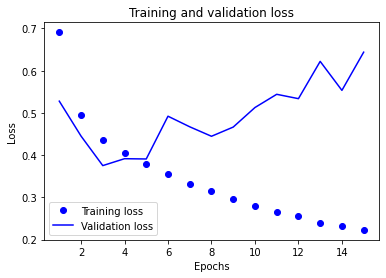

In [81]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

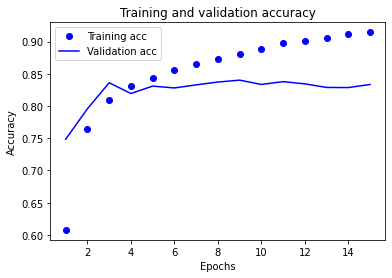

In [82]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* 비슷하다. 차이를 못 느끼겠다.

### 1D Conv

In [147]:
vocab_size = 10000 
word_vector_dim = 64 # 임베딩 차원을 늘려보자

# 모델 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

# Conv1D + BatchNorm + Dropout
model.add(tf.keras.layers.Conv1D(64, 4, activation='relu'))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Dropout(0.5)) 

model.add(tf.keras.layers.Conv1D(32, 4, activation='relu'))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.5)) 

# Dense layer
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5)) 

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 64)          640000    
_________________________________________________________________
conv1d_26 (Conv1D)           (None, None, 64)          16448     
_________________________________________________________________
batch_normalization_43 (Batc (None, None, 64)          256       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, None, 64)          0         
_________________________________________________________________
dropout_43 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, None, 32)          8224      
_________________________________________________________________
batch_normalization_44 (Batc (None, None, 32)        

In [148]:
# 콜백 
checkpoint_path = "best_model_1DConv.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy', 
                             save_best_only=True,
                             verbose=1)

In [149]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/10
392/392 [==============================] - 4s 8ms/step - loss: 0.6727 - accuracy: 0.6157 - val_loss: 0.6427 - val_accuracy: 0.5958

Epoch 00001: val_accuracy improved from -inf to 0.59580, saving model to best_model_1DConv.h5
Epoch 2/10
392/392 [==============================] - 3s 7ms/step - loss: 0.4585 - accuracy: 0.8020 - val_loss: 0.3895 - val_accuracy: 0.8299

Epoch 00002: val_accuracy improved from 0.59580 to 0.82992, saving model to best_model_1DConv.h5
Epoch 3/10
392/392 [==============================] - 3s 7ms/step - loss: 0.3891 - accuracy: 0.8436 - val_loss: 0.3605 - val_accuracy: 0.8427

Epoch 00003: val_accuracy improved from 0.82992 to 0.84273, saving model to best_model_1DConv.h5
Epoch 4/10
392/392 [==============================] - 3s 7ms/step - loss: 0.3518 - accuracy: 0.8623 - val_loss: 0.3530 - val_accuracy: 0.8458

Epoch 00004: val_accuracy improved from 0.84273 to 0.84582, saving model to best_model_1DConv.h5
Epoch 5/10
392/392 [=======================

In [150]:
model.load_weights(checkpoint_path)

# 평가
results = model.evaluate(X_test, y_test, verbose=2)
print("Test Loss, Test Accuracy:", results)

1509/1509 - 3s - loss: 0.3623 - accuracy: 0.8442
Test Loss, Test Accuracy: [0.36226388812065125, 0.8442413806915283]


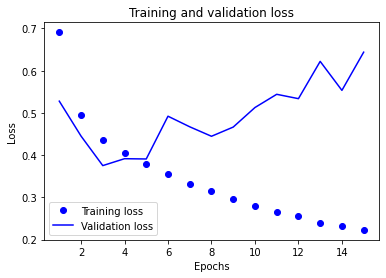

In [151]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

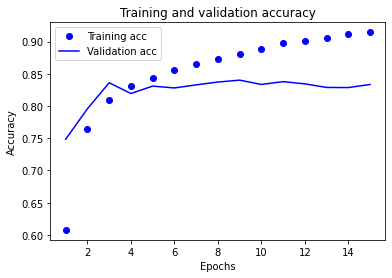

In [152]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* 쥐꼬리만큼 좋아졌다.

### 사전 학습된 임베딩
### 그냥 1DConv or LSTM보다 앞 뒤 정보를 받아오는 1DConv+LSTM을 쓰면 더 좋다고 한다.
* 1DConv에 국소적 정보 학습
* LSTM의 장기기억 + 순차정보 기억 
    * EX) 않, 좋 

In [153]:
# 현재 내 임베딩 가중치 차원
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 64)


In [171]:
from tensorflow.keras.initializers import Constant

# 1. Word2Vec 모델 로드
from gensim.models import Word2Vec
word2vec_path = os.getenv('HOME') + '/data/word2vec_ko.model'  # Word2Vec 한국어 모델 경로
word2vec = Word2Vec.load(word2vec_path)

# 2. word_to_index를 기반으로 index_to_word 생성
index_to_word = {index: word for word, index in word_to_index.items()}

In [172]:
# 얘는 300차원이 아니다. 
print("Word2Vec 벡터 크기:", word2vec.vector_size)

Word2Vec 벡터 크기: 100


In [173]:
# 3. embedding_matrix 초기화
vocab_size = 10000 # 어휘사전크기 동일하게
word_vector_dim = word2vec.vector_size  # Word2Vec 모델과 동일한 차원으로 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# Word2Vec 벡터를 embedding_matrix에 복사
for i in range(3, vocab_size):  # 예제에서 4번 필요없으니 빼고 특수 토큰 3개만 제외
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [193]:
maxlen = 45  #  맥스 시퀀스 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size, 
        output_dim=word_vector_dim, 
        embeddings_initializer=Constant(embedding_matrix),
        input_length=maxlen, 
        trainable=True
    ),
    tf.keras.layers.Conv1D(64, 7, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 45, 100)           1000000   
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 39, 64)            44864     
_________________________________________________________________
batch_normalization_53 (Batc (None, 39, 64)            256       
_________________________________________________________________
dropout_54 (Dropout)         (None, 39, 64)            0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 7, 64)             0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 7, 128)            66048     
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 128)             

In [194]:
# 콜백 
checkpoint_path = "best_model_embedding.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy', 
                             save_best_only=True,
                             verbose=1)

In [195]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/20
392/392 [==============================] - 7s 10ms/step - loss: 0.5727 - accuracy: 0.6973 - val_loss: 0.4761 - val_accuracy: 0.7765

Epoch 00001: val_accuracy improved from -inf to 0.77648, saving model to best_model_embedding.h5
Epoch 2/20
392/392 [==============================] - 3s 9ms/step - loss: 0.4600 - accuracy: 0.7883 - val_loss: 0.4118 - val_accuracy: 0.8063

Epoch 00002: val_accuracy improved from 0.77648 to 0.80628, saving model to best_model_embedding.h5
Epoch 3/20
392/392 [==============================] - 3s 9ms/step - loss: 0.4069 - accuracy: 0.8178 - val_loss: 0.4110 - val_accuracy: 0.8234

Epoch 00003: val_accuracy improved from 0.80628 to 0.82342, saving model to best_model_embedding.h5
Epoch 4/20
392/392 [==============================] - 3s 9ms/step - loss: 0.3747 - accuracy: 0.8338 - val_loss: 0.3975 - val_accuracy: 0.8305

Epoch 00004: val_accuracy improved from 0.82342 to 0.83052, saving model to best_model_embedding.h5
Epoch 5/20
392/392 [==========

In [196]:
model.load_weights(checkpoint_path)

# 평가
results = model.evaluate(X_test, y_test, verbose=2)
print("Test Loss, Test Accuracy:", results)

1509/1509 - 4s - loss: 0.3594 - accuracy: 0.8480
Test Loss, Test Accuracy: [0.3593617379665375, 0.8480120897293091]


* 아직 할 게 더 있다. 

### LeakyReLU+ BatchNormalization + Dropout + 층 쌓기
    * 해당 코드에선 지웠으나 1DConv+ LSTM 층 2개를 활용하면 성능이 더 안 좋다. 

In [227]:
from tensorflow.keras.layers import LeakyReLU

maxlen = 45  

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size, 
        output_dim=word_vector_dim, 
        embeddings_initializer=Constant(embedding_matrix),
        input_length=maxlen, 
        trainable=True
    ),
    tf.keras.layers.Conv1D(256, 6), 
    LeakyReLU(alpha=0.1), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128), 
    LeakyReLU(alpha=0.1), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64), 
    LeakyReLU(alpha=0.1), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32), 
    LeakyReLU(alpha=0.1), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16), 
    LeakyReLU(alpha=0.1), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8),
    LeakyReLU(alpha=0.1),  
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 45, 100)           1000000   
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 40, 256)           153856    
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 40, 256)           0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 40, 256)           1024      
_________________________________________________________________
dropout_124 (Dropout)        (None, 40, 256)           0         
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 8, 256)            0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 8, 512)          

In [228]:
# 콜백 
checkpoint_path = "best_model_embedding.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1)

In [229]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128, # 배치 사이즈도 작게
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/15
783/783 [==============================] - 13s 13ms/step - loss: 0.6896 - accuracy: 0.5227 - val_loss: 0.6134 - val_accuracy: 0.6869

Epoch 00001: val_accuracy improved from -inf to 0.68692, saving model to best_model_embedding.h5
Epoch 2/15
783/783 [==============================] - 9s 12ms/step - loss: 0.5174 - accuracy: 0.7606 - val_loss: 0.4305 - val_accuracy: 0.8059

Epoch 00002: val_accuracy improved from 0.68692 to 0.80593, saving model to best_model_embedding.h5
Epoch 3/15
783/783 [==============================] - 9s 12ms/step - loss: 0.4154 - accuracy: 0.8196 - val_loss: 0.3748 - val_accuracy: 0.8322

Epoch 00003: val_accuracy improved from 0.80593 to 0.83225, saving model to best_model_embedding.h5
Epoch 4/15
783/783 [==============================] - 9s 12ms/step - loss: 0.3724 - accuracy: 0.8413 - val_loss: 0.3704 - val_accuracy: 0.8421

Epoch 00004: val_accuracy improved from 0.83225 to 0.84212, saving model to best_model_embedding.h5
Epoch 5/15
783/783 [======

### 대충 몇번 하이퍼파라미터 조정하니까 넘겼다. overfitting이 굉장히 빨리 일어난다. 7번째

In [230]:
model.load_weights(checkpoint_path)

# 평가
results = model.evaluate(X_test, y_test, verbose=2)
print("Test Loss, Test Accuracy:", results)

1509/1509 - 4s - loss: 0.3494 - accuracy: 0.8504
Test Loss, Test Accuracy: [0.34935885667800903, 0.8503532409667969]


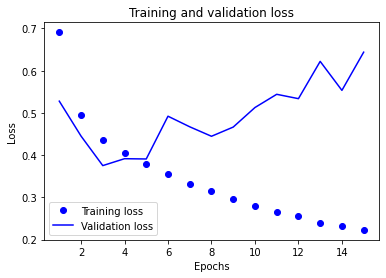

In [231]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

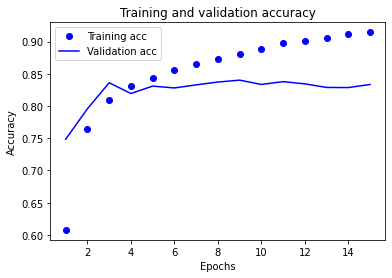

In [232]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회고
* 전처리를 좀 더 하면 더 성능이 좋을 것이다. 
* 불용어에서 데이터를 제외시켰는데, 한국어의 특성 상 조사를 더욱 많은 형태로 제외시킬 필요성이 있어보인다.
* 욕설을 비롯한 블라인드 처리와 반어법 등 그 밖에도 생각해볼 요소가 많다. 
* 트랜스포머 모델에도 한 번 돌려볼 법? 하다.